In [29]:
import pandas as pd
import re
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag
from nltk.chunk import ne_chunk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

In [30]:
# Download necessary NLTK data
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('maxent_ne_chunker')
nltk.download('words')
nltk.download('vader_lexicon')
nltk.download('maxent_ne_chunker_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package maxent_ne_chunker_tab to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package ma

True

In [31]:
# Step 1: Collect tweets (In this case, load from CSV)
def load_tweets(file_path, num_samples=10000):
    df = pd.read_csv(file_path, encoding='latin-1', header=None,
                     names=['target', 'id', 'date', 'flag', 'user', 'text'])
    return df.sample(n=num_samples, random_state=42)


In [32]:
# Step 2: Pre-process tweets
def preprocess_tweet(text):
    text = text.lower()
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text


In [45]:

# Step 3: Apply sentiment analysis
def analyze_sentiment(text):
    sia = SentimentIntensityAnalyzer()
    return sia.polarity_scores(text)['compound']

# Step 4: Apply named entity recognition
def extract_entities(text):
    tokens = word_tokenize(text)
    pos_tags = pos_tag(tokens)
    tree = ne_chunk(pos_tags)
    entities = []
    for subtree in tree:
        if isinstance(subtree, nltk.Tree):
            entities.append((subtree.label(), ' '.join([token for token, pos in subtree.leaves()])))
    return entities

# Step 5: Cluster tweets
def cluster_tweets(texts, n_clusters=5):
    vectorizer = TfidfVectorizer(max_features=1000)
    X = vectorizer.fit_transform(texts)
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(X)
    return kmeans.labels_

# Step 6: Visualize analysis
def visualize_analysis_sentiment(df):
    # Sentiment distribution
    plt.figure(figsize=(10, 5))
    sns.histplot(df['sentiment'], bins=50, kde=True)
    plt.title('Sentiment Distribution')
    plt.xlabel('Sentiment Score')
    plt.savefig('sentiment_distribution.png')
    plt.show()
    plt.close()

def visualize_analysis_entities(df):
    # Top entities
    entity_counts = df['entities'].explode().value_counts()
    if not entity_counts.empty:
        entity_counts = entity_counts.head(10)
        plt.figure(figsize=(12, 6))
        entity_counts.plot(kind='bar')
        plt.title('Top 10 Named Entities')
        plt.xlabel('Entity')
        plt.ylabel('Frequency')
        plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
        plt.tight_layout()
        plt.show()
        plt.savefig('named_entities.png')

def visualize_analysis_clusters(df):
    # Cluster visualization (using t-SNE for dimensionality reduction)
    from sklearn.manifold import TSNE
    vectorizer = TfidfVectorizer(max_features=1000)
    X = vectorizer.fit_transform(df['processed_text'])
    tsne = TSNE(n_components=2, random_state=42)
    tsne_results = tsne.fit_transform(X.toarray())

    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=df['cluster'], cmap='viridis')
    plt.colorbar(scatter)
    plt.title('Tweet Clusters Visualization')
    plt.xlabel('t-SNE 1')
    plt.ylabel('t-SNE 2')
    plt.savefig('tweet_clusters.png')
    plt.show()
    plt.close()


In [34]:
# Step 1: Load tweets
df = load_tweets('https://github.com/prathameshks/College-Code-sem7/raw/refs/heads/main/ML-Honors%20AIML/Practical%204/data.csv', num_samples=1000)


In [35]:
df.head()

,target,id,date,flag,user,text
80956,0,1752531368,Sat May 09 22:11:06 PDT 2009,NO_QUERY,TrishGoger,so.. cold..
109622,0,1824611419,Sun May 17 02:08:36 PDT 2009,NO_QUERY,xeeko,sick! cold! cough! and fever! just at the mis...
148312,0,1883094112,Fri May 22 07:59:57 PDT 2009,NO_QUERY,iamsuebee,@_theX . . . And yet you never come to Beantow...
79883,0,1752047759,Sat May 09 20:55:31 PDT 2009,NO_QUERY,JKlover,@JenAlaniz Wasn't it though! I love the 90's! ...
267821,0,1989271965,Mon Jun 01 00:56:56 PDT 2009,NO_QUERY,SuperDunner,"@DirtyDiva sorry, but @jeffrubenstein didn't w..."


In [36]:
# Step 2: Pre-process tweets
df['processed_text'] = df['text'].apply(preprocess_tweet)


In [37]:
df.head()

,target,id,date,flag,user,text,processed_text
80956,0,1752531368,Sat May 09 22:11:06 PDT 2009,NO_QUERY,TrishGoger,so.. cold..,so cold
109622,0,1824611419,Sun May 17 02:08:36 PDT 2009,NO_QUERY,xeeko,sick! cold! cough! and fever! just at the mis...,sick cold cough and fever just at the mist of ...
148312,0,1883094112,Fri May 22 07:59:57 PDT 2009,NO_QUERY,iamsuebee,@_theX . . . And yet you never come to Beantow...,and yet you never come to beantown smh haha
79883,0,1752047759,Sat May 09 20:55:31 PDT 2009,NO_QUERY,JKlover,@JenAlaniz Wasn't it though! I love the 90's! ...,wasnt it though i love the 90s and the 80s so ...
267821,0,1989271965,Mon Jun 01 00:56:56 PDT 2009,NO_QUERY,SuperDunner,"@DirtyDiva sorry, but @jeffrubenstein didn't w...",sorry but didnt want any of my hugs


In [38]:
# Step 3: Apply sentiment analysis
df['sentiment'] = df['processed_text'].apply(analyze_sentiment)


In [39]:
df.head()

,target,id,date,flag,user,text,processed_text,sentiment
80956,0,1752531368,Sat May 09 22:11:06 PDT 2009,NO_QUERY,TrishGoger,so.. cold..,so cold,0.0000
109622,0,1824611419,Sun May 17 02:08:36 PDT 2009,NO_QUERY,xeeko,sick! cold! cough! and fever! just at the mis...,sick cold cough and fever just at the mist of ...,-0.5106
148312,0,1883094112,Fri May 22 07:59:57 PDT 2009,NO_QUERY,iamsuebee,@_theX . . . And yet you never come to Beantow...,and yet you never come to beantown smh haha,0.1779
79883,0,1752047759,Sat May 09 20:55:31 PDT 2009,NO_QUERY,JKlover,@JenAlaniz Wasn't it though! I love the 90's! ...,wasnt it though i love the 90s and the 80s so ...,-0.6103
267821,0,1989271965,Mon Jun 01 00:56:56 PDT 2009,NO_QUERY,SuperDunner,"@DirtyDiva sorry, but @jeffrubenstein didn't w...",sorry but didnt want any of my hugs,0.5882


In [40]:
# Step 4: Apply named entity recognition
df['entities'] = df['processed_text'].apply(extract_entities)

In [41]:
df.head()

,target,id,date,flag,user,text,processed_text,sentiment,entities
80956,0,1752531368,Sat May 09 22:11:06 PDT 2009,NO_QUERY,TrishGoger,so.. cold..,so cold,0.0000,[]
109622,0,1824611419,Sun May 17 02:08:36 PDT 2009,NO_QUERY,xeeko,sick! cold! cough! and fever! just at the mis...,sick cold cough and fever just at the mist of ...,-0.5106,[]
148312,0,1883094112,Fri May 22 07:59:57 PDT 2009,NO_QUERY,iamsuebee,@_theX . . . And yet you never come to Beantow...,and yet you never come to beantown smh haha,0.1779,[]
79883,0,1752047759,Sat May 09 20:55:31 PDT 2009,NO_QUERY,JKlover,@JenAlaniz Wasn't it though! I love the 90's! ...,wasnt it though i love the 90s and the 80s so ...,-0.6103,[]
267821,0,1989271965,Mon Jun 01 00:56:56 PDT 2009,NO_QUERY,SuperDunner,"@DirtyDiva sorry, but @jeffrubenstein didn't w...",sorry but didnt want any of my hugs,0.5882,[]


In [42]:
# Step 5: Cluster tweets
df['cluster'] = cluster_tweets(df['processed_text'])

In [43]:
df.head()

,target,id,date,flag,user,text,processed_text,sentiment,entities,cluster
80956,0,1752531368,Sat May 09 22:11:06 PDT 2009,NO_QUERY,TrishGoger,so.. cold..,so cold,0.0000,[],1
109622,0,1824611419,Sun May 17 02:08:36 PDT 2009,NO_QUERY,xeeko,sick! cold! cough! and fever! just at the mis...,sick cold cough and fever just at the mist of ...,-0.5106,[],2
148312,0,1883094112,Fri May 22 07:59:57 PDT 2009,NO_QUERY,iamsuebee,@_theX . . . And yet you never come to Beantow...,and yet you never come to beantown smh haha,0.1779,[],4
79883,0,1752047759,Sat May 09 20:55:31 PDT 2009,NO_QUERY,JKlover,@JenAlaniz Wasn't it though! I love the 90's! ...,wasnt it though i love the 90s and the 80s so ...,-0.6103,[],1
267821,0,1989271965,Mon Jun 01 00:56:56 PDT 2009,NO_QUERY,SuperDunner,"@DirtyDiva sorry, but @jeffrubenstein didn't w...",sorry but didnt want any of my hugs,0.5882,[],3


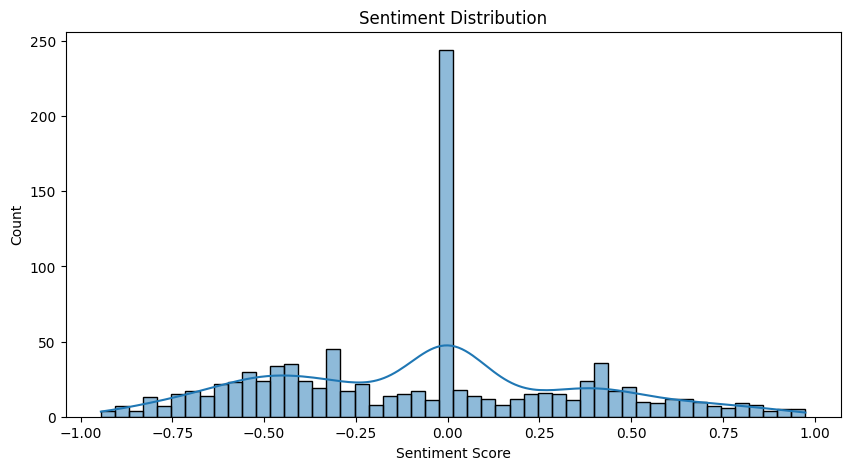

In [46]:
# Step 6: Visualize analysis
visualize_analysis_sentiment(df)

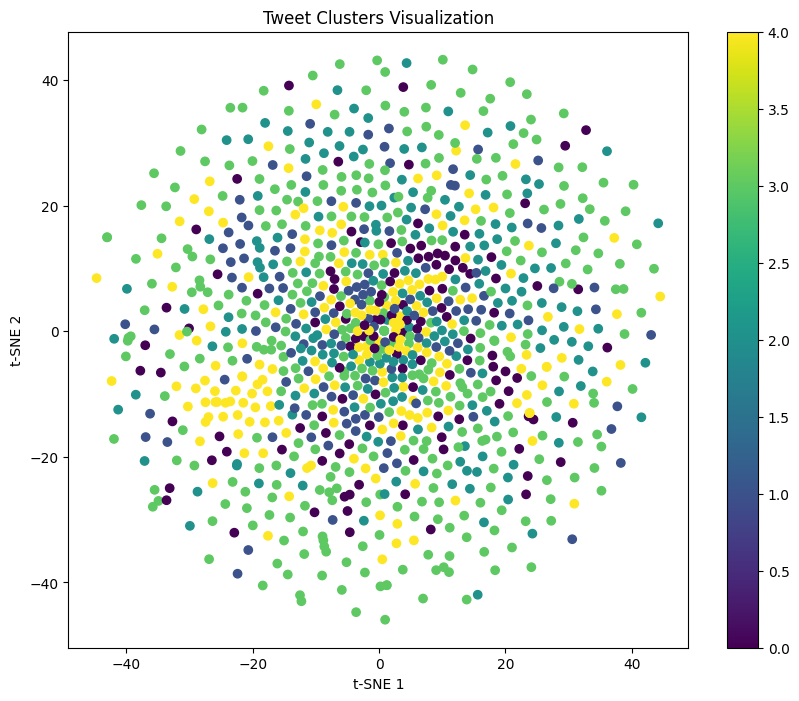

In [47]:
visualize_analysis_clusters(df)

In [48]:
visualize_analysis_entities(df)